In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy
import matplotlib.colors as mcolors
import networkx as nx
import pickle
import copy

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_wc, cost_functions

import matplotlib as mpl
label_size= 20
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
mpl.rcParams['font.size'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.linewidth'] = 1

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

while "Promotion/neurolib" in os.getcwd():
    os.chdir('..')

pickledir = os.path.join(os.getcwd(), "neurolib_aln_osc_datastorage/optimal_control/WP2/2n")
dir = os.path.join(pickledir, "images_2n_wc_fourier")

print(dir)

def get_period(timeseries, dt):
    peaks = scipy.signal.find_peaks(timeseries, prominence=0.001)[0]
    periods = []
    for i in range(1, len(peaks)-1):
        periods.append( (peaks[i] - peaks[i-1]) * dt)
    return np.mean(periods)

/home/lena/Promotion/neurolib_aln_osc_datastorage/optimal_control/WP2/2n/images_2n_wc_fourier


In [2]:
p_names = ["Osc", "Bi-phase-osc", "Beat", "Bi-period-osc", "Bi-stat-osc"]
coords = [[0.9, 0.0], [1.7, 0.8], [1.4, 0.6], [1.1, 0.5], [2.1, 0.8]]

for i in range(len(p_names)):
    p = p_names[i]
    data[p]["coordinates"] = coords[i]

NameError: name 'data' is not defined

In [3]:
def plotspectrum(data, fmax=1., filename=None):

    for d in data:
        ps = np.abs(np.fft.fft(d))
        ps_plot = ps[:int(len(ps)/2)]

        fr = np.linspace(0,1./(2.*dt),len(ps_plot))

        plt.plot(fr, ps_plot)

    plt.xlim(-0.01,fmax)
    plt.ylim(0,1.1*np.amax(ps_plot))
    plt.tight_layout()

    if filename is not None:
        plt.savefig(os.path.join(dir, filename))
    
    plt.show()

    maxfreqind = np.where(ps_plot == max(ps_plot[1:]))
    print("freq of max = ", fr[maxfreqind])
    print("period of max = ", 1./fr[maxfreqind])

    return (1./fr[maxfreqind])[0]

def plot_EI_trajectory(m, tstart= 10000, filename=None):

    plt.plot(m.exc[0,tstart:], m.inh[0,tstart:], color="gray", linewidth=1)
    #plt.plot(m.exc[1,tstart:], m.inh[1,tstart:], color="gray", linewidth=2, linestyle=":")

    plt.xlabel("E")
    plt.ylabel("I")
    plt.tight_layout()

    if filename is not None:
        plt.savefig(os.path.join(dir, filename))


    plt.show()

    return

def recurrence_plot(data, threshold=0.01):
    N = len(data)
    distance_matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            distance_matrix[i, j] = np.abs(data[i] - data[j])

    # Create the recurrence plot
    recurrence_plot = np.where(distance_matrix <= threshold, 1, 0)

    return recurrence_plot

def show_recplot(data, threshold=0.1):
    plt.figure(figsize=(8, 8))
    recurrence=recurrence_plot(data, threshold)
    plt.imshow(recurrence, cmap='binary', origin='lower')
    plt.title('Recurrence Plot')
    plt.xlabel('Time')
    plt.ylabel('Time')
    plt.colorbar(label='Recurrence')
    plt.show()

    return


Osc


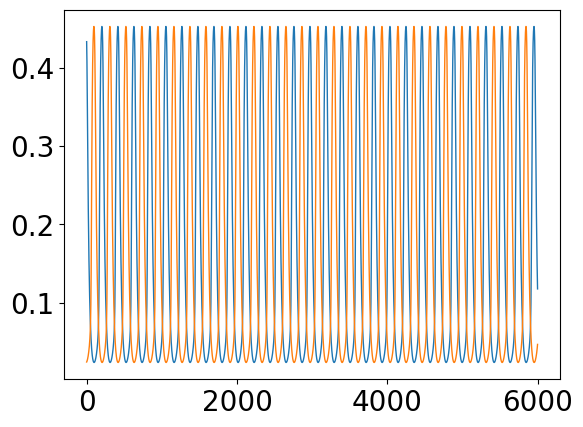

Beat


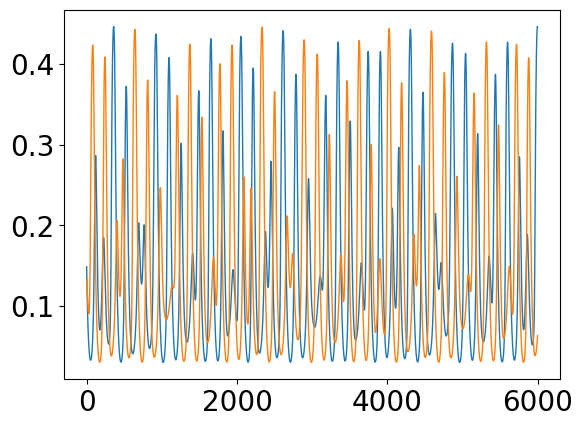

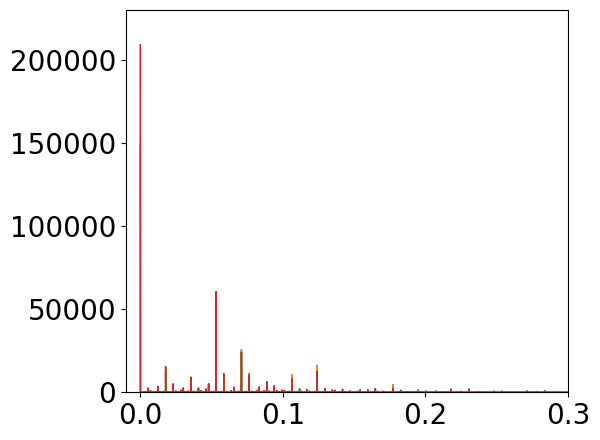

freq of max =  [0.05321011]
period of max =  [18.79342229]


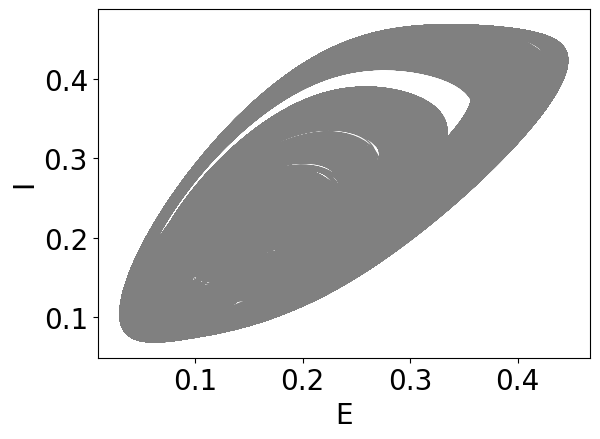

Bi-phase-osc


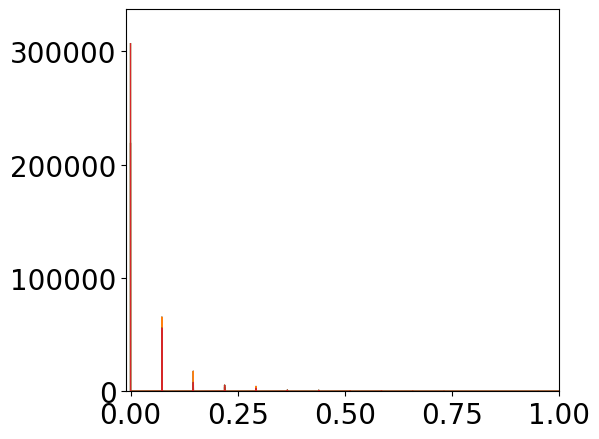

freq of max =  [0.07321015]
period of max =  [13.65930884]


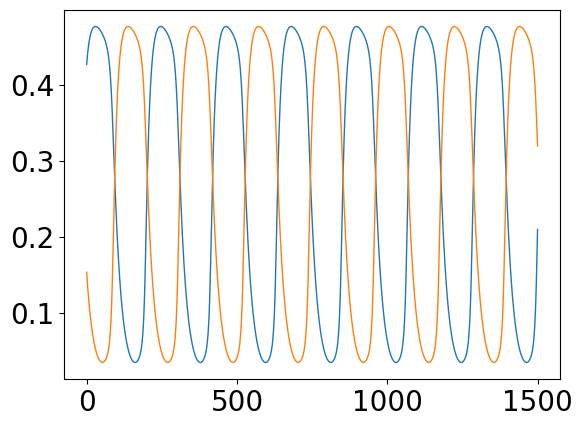

Bi-stat-osc


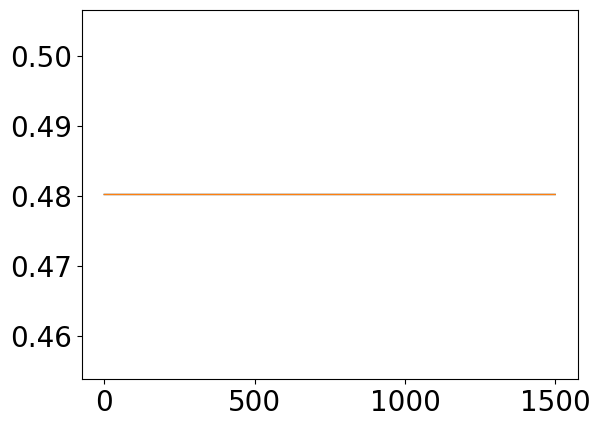

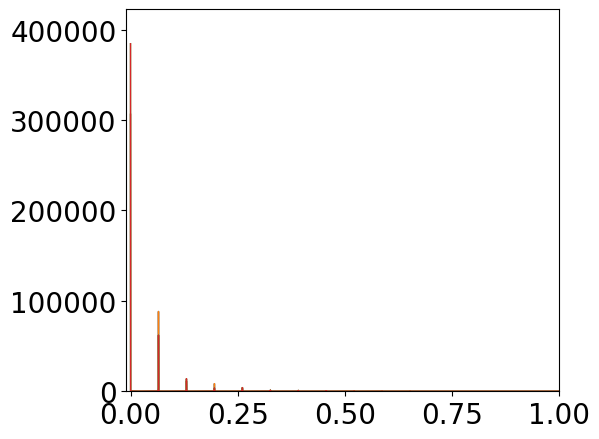

freq of max =  [0.06529013]
period of max =  [15.31625057]
Bi-period-osc


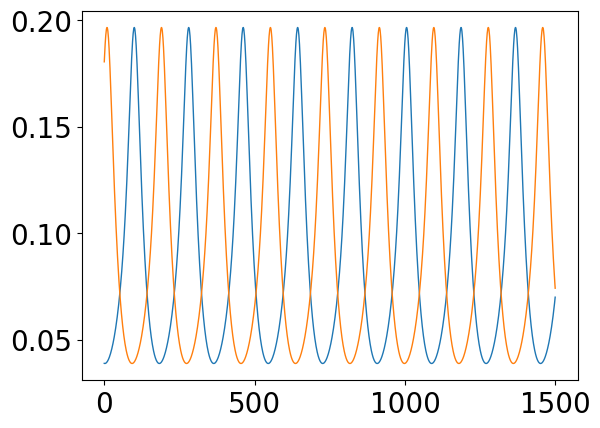

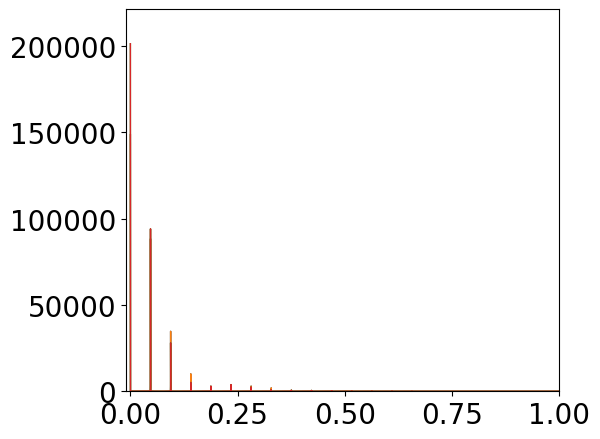

freq of max =  [0.04695009]
period of max =  [21.29921193]


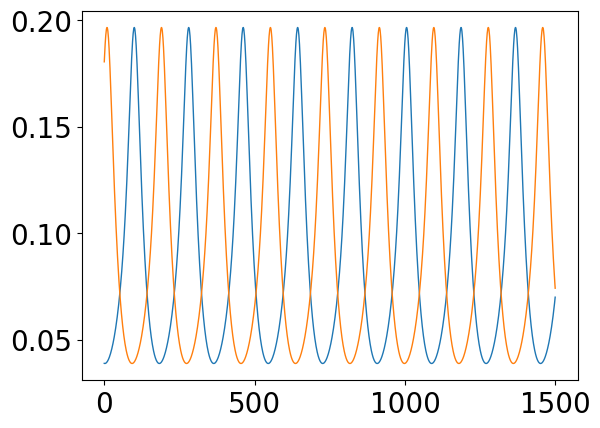

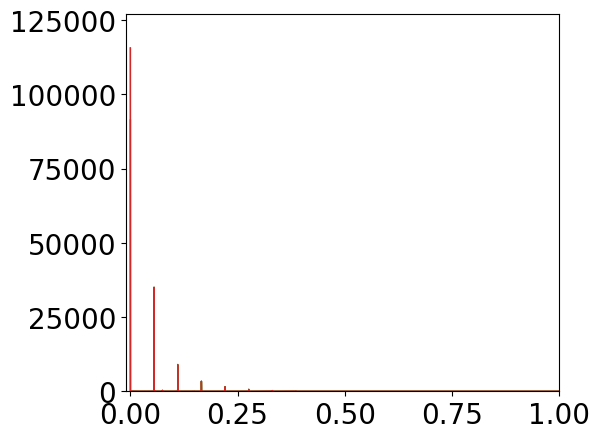

freq of max =  [0.05523011]
period of max =  [18.10606554]


In [4]:
coupling = 1.8
cmat = np.array( [[0., 1.], [1., 0.]] )
N = cmat.shape[0]

if True:
    data = dict()

    for i in range(len(p_names)):
        p = p_names[i]
        data[p] = dict()
        data[p]["coordinates"] = coords[i]
        data[p]["delay"] = 9.5

        if "Bi-period" in p:
            data[p]["control"] = [[None, None], [None, None]]
            data[p]["state"] = [[None, None], [None, None]]
            data[p]["init_state"] = [None, None]
            data[p]["weight"] = [[1., 1.], [1., 1.]]
            data[p]["dur/per"] = [[1000., 20], [1000., 20]]
            data[p]["target_period"] = [20., 20.]
        else:
            data[p]["control"] = [None, None]
            data[p]["state"] = [None, None]
            data[p]["init_state"] = None
            data[p]["weight"] = [1., 1.]
            data[p]["dur/per"] = [1000., 20]
            data[p]["target_period"] = 20.


duration = 100000.
dt = 0.1


test_input_plus = ZeroInput().generate_input(duration=duration+dt, dt=dt)
test_input_plus[:,:500] = 5.

test_input_minus = ZeroInput().generate_input(duration=duration+dt, dt=dt)
test_input_minus[:,:500] = -5.

test_input_phase = ZeroInput().generate_input(duration=duration+dt, dt=dt)
test_input_phase = np.vstack( ([test_input_phase]*N))
test_input_phase[0,:500] = np.sin(2.*np.pi*np.arange(0,50,dt)/20.)
test_input_phase[1,:500] = - np.sin(2.*np.pi*np.arange(0,50,dt)/20.)

test_inputin__phase = ZeroInput().generate_input(duration=duration+dt, dt=dt)
test_inputin__phase = np.vstack( ([test_input_phase]*N))
test_inputin__phase[0,:500] = np.sin(2.*np.pi*np.arange(0,50,dt)/20.)
test_inputin__phase[1,:500] = np.sin(2.*np.pi*np.arange(0,50,dt)/20.)

for pi in range(len(p_names)):

    if "Bi" in p_names[pi]:
        continue

    print(p_names[pi])

    model = WCModel(Cmat=cmat, Dmat=data[p_names[pi]]["delay"]*20.*cmat)

    model.params['duration'] = duration
    model.params.exc_ext_baseline = data[p_names[pi]]["coordinates"][0]
    model.params.inh_ext_baseline = data[p_names[pi]]["coordinates"][1]
    #model.params["exc_ext"] = test_input_minus
    # minus: async after long time / beat after long time
    # plus: async after long time / beat after long time
    # none: async after long time / beat after long time

    model.params.K_gl = coupling
    model.run()
    nmaxdelay = model.getMaxDelay()

    einit = np.zeros((N, nmaxdelay+1))
    iinit = np.zeros((N, nmaxdelay+1))

    for n in range(N):
        einit[n,:] = model.exc[n,-nmaxdelay-1:]
        iinit[n,:] = model.inh[n,-nmaxdelay-1:]

    data[p_names[pi]]["init_state"] = [einit, iinit]

    plt.plot(model.exc[0,-6000:])
    plt.plot(model.exc[1,-6000:])
    plt.show()

    if "Beat" in p_names[pi]:
        data[p]["target_period"] = plotspectrum( [model.exc[0,:], model.exc[1,:], model.inh[0,:], model.inh[0,:]], fmax=0.3, filename="beat_spectrum")
        plot_EI_trajectory(model, filename="beat_trajectory")
    #show_recplot(model.exc[0,90000:], threshold=0.1)

if True:
    p = "Bi-phase-osc"

    print(p)

    model = WCModel(Cmat=cmat, Dmat=data[p]["delay"]*20.*cmat)

    model.params['duration'] = duration
    model.params.exc_ext_baseline = data[p]["coordinates"][0]
    model.params.inh_ext_baseline = data[p]["coordinates"][1]
    model.params.K_gl = coupling
    nmaxdelay = model.getMaxDelay()

    model.params["exc_ext"] = test_inputin__phase
    model.run()

    data[p]["target_period"] = plotspectrum( [model.exc[0,:], model.exc[1,:], model.inh[0,:], model.inh[0,:]])

    model.params["exc_ext"] = test_input_phase
    model.run()

    plt.plot(model.exc[0,-1500:])
    plt.plot(model.exc[1,-1500:])
    plt.show()

    einit = np.zeros((N, nmaxdelay+1))
    iinit = np.zeros((N, nmaxdelay+1))

    for n in range(N):
        einit[n,:] = model.exc[n,-nmaxdelay-1:]
        iinit[n,:] = model.inh[n,-nmaxdelay-1:]

    data[p]["init_state"] = [einit, iinit]

##########################################

if True:
    p = "Bi-stat-osc"

    print(p)

    model = WCModel(Cmat=cmat, Dmat=data[p]["delay"]*20.*cmat)

    model.params['duration'] = duration
    model.params.exc_ext_baseline = data[p]["coordinates"][0]
    model.params.inh_ext_baseline = data[p]["coordinates"][1]
    model.params.K_gl = coupling
    nmaxdelay = model.getMaxDelay()

    model.params["exc_ext"] = test_input_plus
    model.run()

    plt.plot(model.exc[0,-1500:])
    plt.plot(model.exc[1,-1500:])
    plt.show()

    einit = np.zeros((N, nmaxdelay+1))
    iinit = np.zeros((N, nmaxdelay+1))

    for n in range(N):
        einit[n,:] = model.exc[n,-nmaxdelay-1:]
        iinit[n,:] = model.inh[n,-nmaxdelay-1:]

    data[p]["init_state"] = [einit, iinit]

    model.params["exc_ext"] = test_input_minus
    model.run()

    data[p]["target_period"] = plotspectrum( [model.exc[0,:], model.exc[1,:], model.inh[0,:], model.inh[0,:]])

##########################################
if True:
    p = "Bi-period-osc"

    print(p)

    model = WCModel(Cmat=cmat, Dmat=data[p]["delay"]*20.*cmat)

    model.params['duration'] = duration
    model.params.exc_ext_baseline = data[p]["coordinates"][0]
    model.params.inh_ext_baseline = data[p]["coordinates"][1]
    model.params.K_gl = coupling
    nmaxdelay = model.getMaxDelay()

    model.params["exc_ext"] = test_input_plus
    model.run()

    plt.plot(model.exc[0,-1500:])
    plt.plot(model.exc[1,-1500:])
    plt.show()

    einit = np.zeros((N, nmaxdelay+1))
    iinit = np.zeros((N, nmaxdelay+1))

    for n in range(N):
        einit[n,:] = model.exc[n,-nmaxdelay-1:]
        iinit[n,:] = model.inh[n,-nmaxdelay-1:]

    data[p]["init_state"][0] = [einit, iinit]

    model.params["exc_ext"] = test_input_phase
    model.run()

    tp0 = plotspectrum( [model.exc[0,:], model.exc[1,:], model.inh[0,:], model.inh[0,:]])

    model.params["exc_ext"] = test_input_plus
    model.run()

    plt.plot(model.exc[0,-1500:])
    plt.plot(model.exc[1,-1500:])
    plt.show()

    einit = np.zeros((N, nmaxdelay+1))
    iinit = np.zeros((N, nmaxdelay+1))

    for n in range(N):
        einit[n,:] = model.exc[n,-nmaxdelay-1:]
        iinit[n,:] = model.inh[n,-nmaxdelay-1:]

    data[p]["init_state"][1] = [einit, iinit]

    model.params["exc_ext"] = test_input_minus
    model.run()

    tp1 = plotspectrum( [model.exc[0,:], model.exc[1,:], model.inh[0,:], model.inh[0,:]])
    
    data[p]["target_period"] = [tp0, tp1]

In [5]:
controlmat = np.ones((N,2))

costmat = np.zeros((N, 2))
costmat[:,0] = 1.

it = 50
maxstr = 5

pr = np.arange(0,1001,20)
testd = 1000.

zero_input0 = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
zero_control = np.vstack( ([zero_input]*N))

In [6]:
def optimize_model(model, exprange):
    for l in range(2):
        for k in exprange:
            model.zero_step_encountered = False
            model.step = 10**(k)
            model.optimize(it)
        model.control_matrix = controlmat
    model.zero_step_encountered = False

    return

["Osc", "Bi-phase-osc", "Beat", "Bi-period-osc", "Bi-stat-osc"]

['Osc', 'Bi-phase-osc', 'Beat', 'Bi-period-osc', 'Bi-stat-osc']

In [85]:
data["Osc"]["weight"] = [1. * 1e-5, 1. * 1e-4]
data["Bi-phase-osc"]["weight"] = [1. * 1e-3, 1. * 1e-2]
data["Beat"]["weight"] = [5. * 1e-5, 5. * 1e-4]
data["Bi-stat-osc"]["weight"] = [4. * 1e-3, 4. * 1e-2]

data["Osc"]["dur/per"] = [600., 20]
data["Bi-phase-osc"]["dur/per"] = [600., 20]
data["Beat"]["dur/per"] = [450., 20]
data["Bi-stat-osc"]["dur/per"] = [600., 20]

Point  Bi-stat-osc
target period, max delay =  15.316250574360545 95
duration =  600.0
500 3563
w2 =  0.004
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.035915848396186
Final cost : -0.03591584839848708
Compute control for a deterministic system
Cost in iteration 0: -0.03591584839848708
Final cost : -0.035915848628609096
Compute control for a deterministic system
Cost in iteration 0: -0.035915848628609096
Final cost : -0.03591587163261385
Compute control for a deterministic system
Cost in iteration 0: -0.03591587163261385
Final cost : -0.03591809238765904
Compute control for a deterministic system
Cost in iteration 0: -0.03591809238765904
Final cost : -0.03600365335941555
Compute control for a deterministic system
Cost in iteration 0: -0.03600365335941555
Final cost : -0.03620797679367928
Compute control for a deterministic system
Cost in iteration 0: -0.03620797679367928
Final cost : -0.03622567169832368
Compute cont

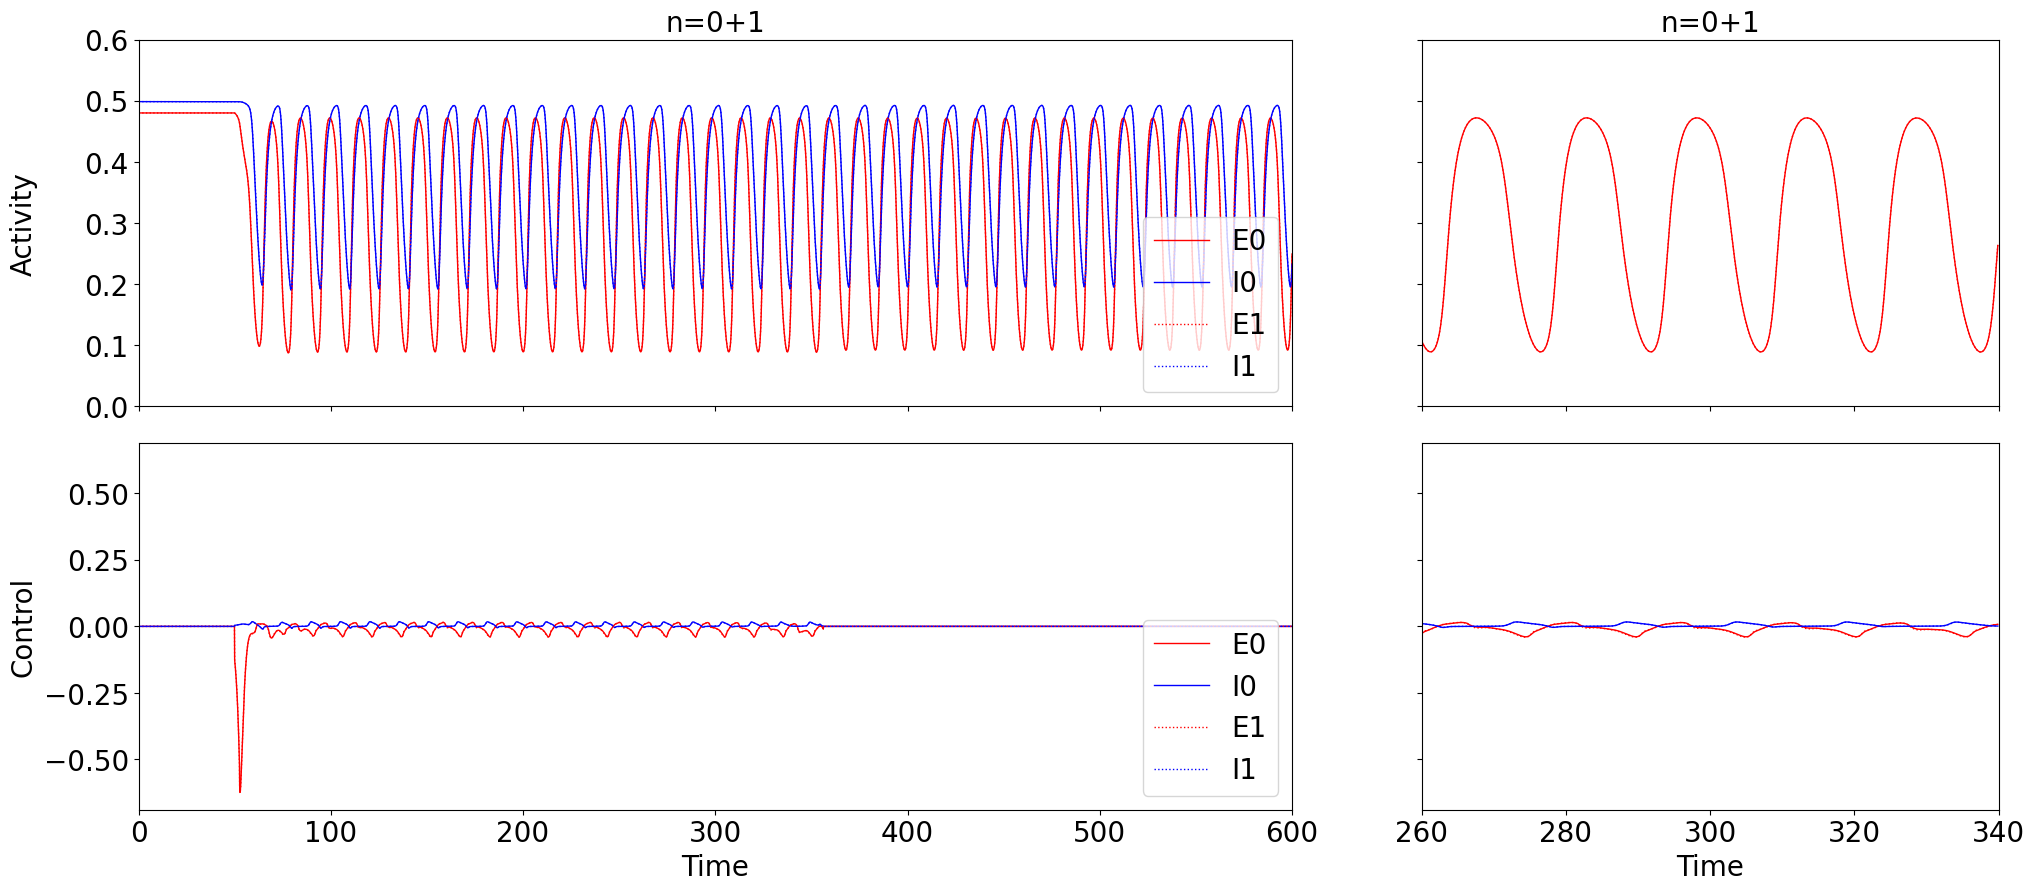

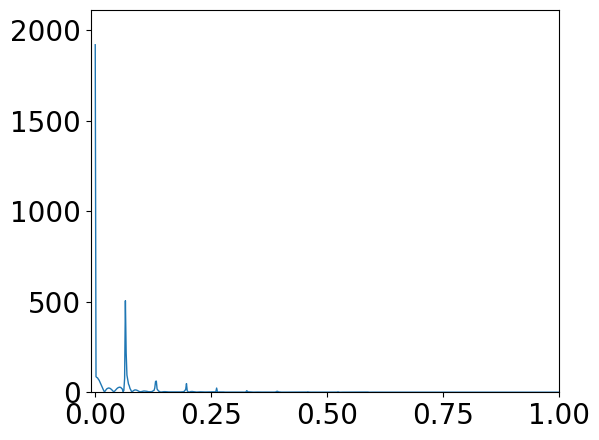

freq of max =  [0.06502167]
period of max =  [15.37948718]


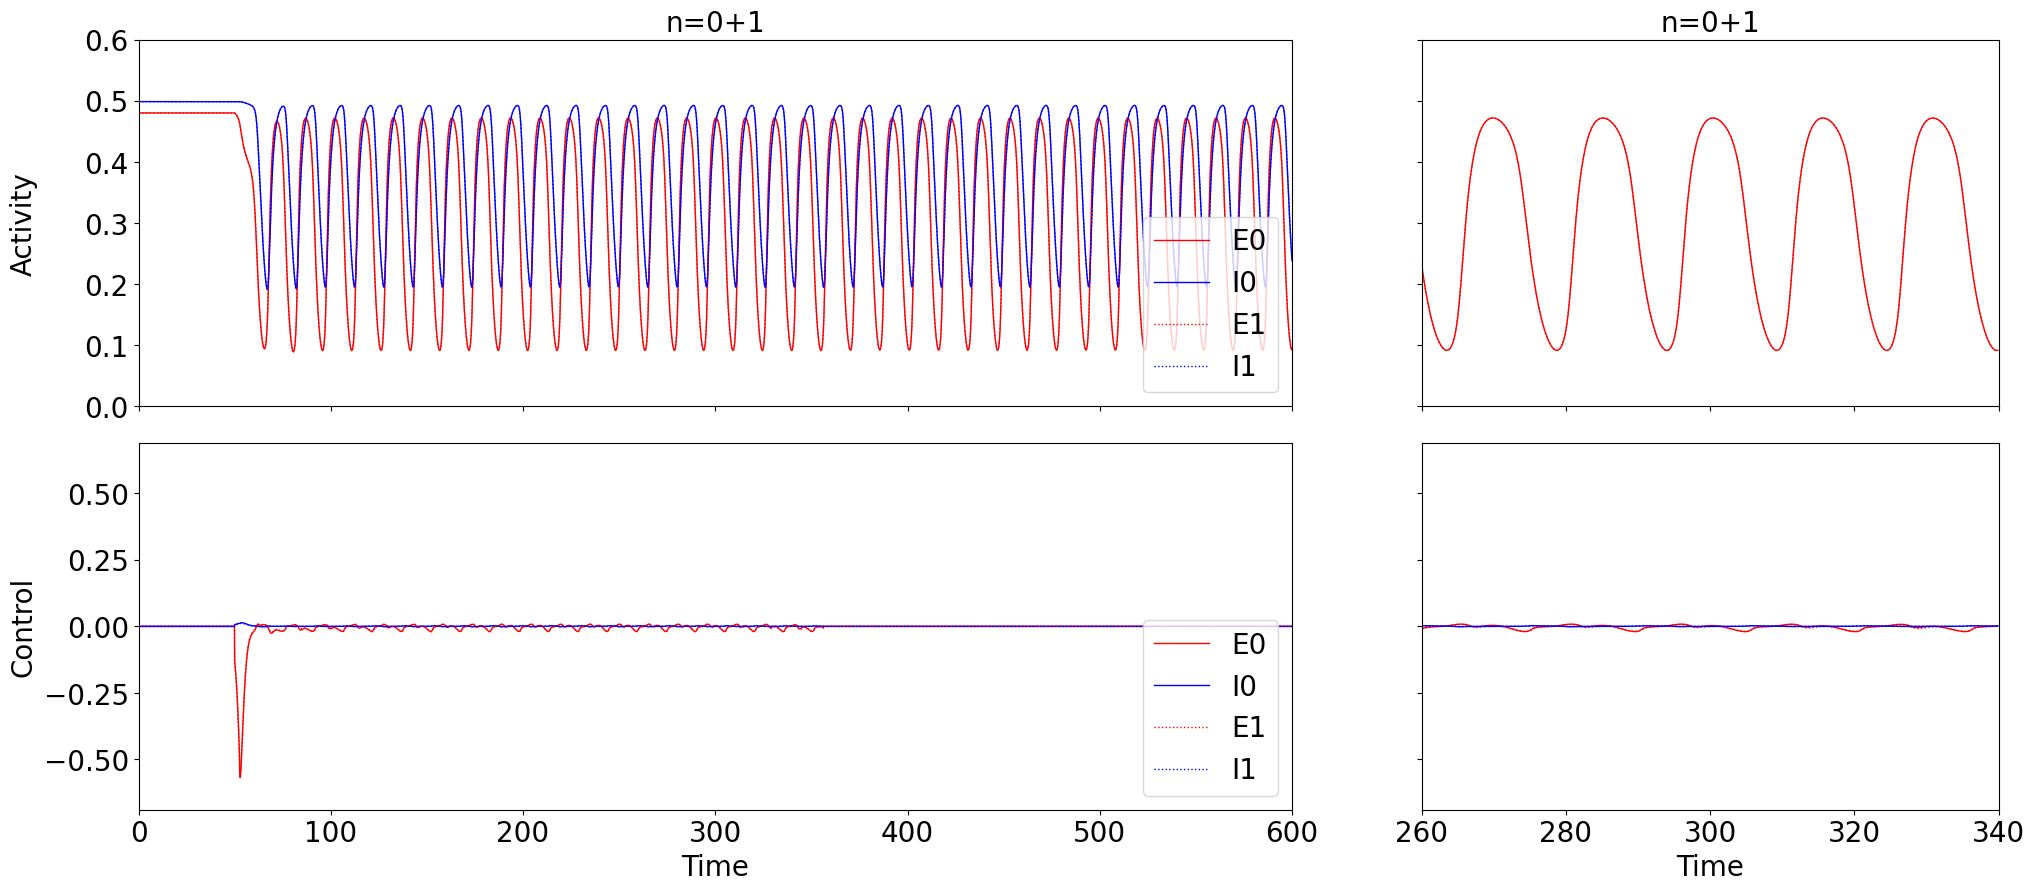

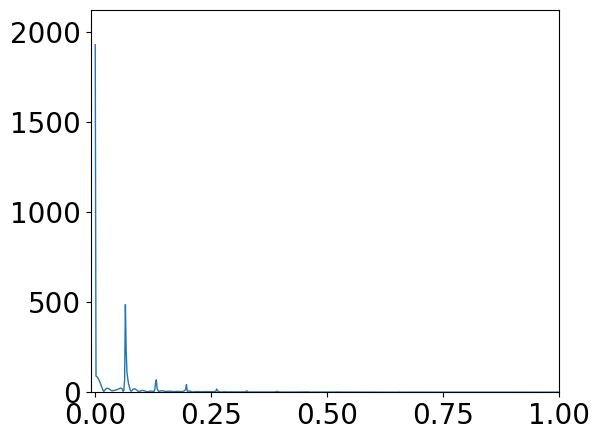

freq of max =  [0.06502167]
period of max =  [15.37948718]


In [118]:
it = 10

for pi in range(len(p_names)):
    p = p_names[pi]

    if "Bi-period" in p:
        continue

    if pi not in [4]: continue

    print("Point ", p)
      
    target_period = data[p]["target_period"]

    model = WCModel(Cmat=cmat, Dmat=data[p_names[pi]]["delay"]*20.*cmat)
    nmaxdelay = model.getMaxDelay()
    print("target period, max delay = ", target_period, nmaxdelay)

    model.params["exc_ext_baseline"] =  data[p]["coordinates"][0]
    model.params["inh_ext_baseline"] =  data[p]["coordinates"][1]
    model.params.K_gl = coupling
        
    model.params.duration = data[p]["dur/per"][0]
    print("duration = ", model.params.duration)

    zero_input0 = ZeroInput().generate_input(duration=model.params.duration+model.params.dt, dt=model.params.dt)
    zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
    zero_control = np.vstack( ([zero_input]*N))
    zero_control = np.vstack( ([zero_input]*N))
    model.params["exc_ext"] = zero_control[:,0,:]
    model.params["inh_ext"] = zero_control[:,1,:]

    model.params["exc_init"] = data[p]["init_state"][0]
    model.params["inh_init"] = data[p]["init_state"][1]

    model.run()
    
    int0 = 500
    int1 = int0 + int(data[p]["dur/per"][1]*target_period/dt)
    print(int0, int1)

    for wi, w2 in enumerate(data[p]["weight"]):

        #if wi not in [1]: continue

        print("w2 = ",w2)

        for factor in [1]:
        #for factor in np.random.random(10):

            model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,None), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat)
            model_controlled.weights["w_p"] = 0.
            model_controlled.weights["w_2"] = w2 * factor
            model_controlled.weights["w_f_sync"] = 1.

            model_controlled.maximum_control_strength = maxstr

            if True:
                if type(data[p]["control"][wi]) != type(None):
                    model_controlled.control = data[p]["control"][wi].copy()
                    model_controlled.update_input()
                else:
                    model_controlled.control += 1e-3
                    model_controlled.update_input()

            for j in range(1):
                model_controlled.grad_method = 0
                model_controlled.channelwise_optimization = True

                for l in range(1):
                    for k in np.arange(-10., 30., 2.):
                        model_controlled.zero_step_encountered = False
                        model_controlled.step = 10**(k)
                        model_controlled.optimize(it)

                model_controlled.grad_method = 1
                model_controlled.channelwise_optimization = True

                for l in range(1):
                    for k in np.arange(-9., 9., 2.):
                        model_controlled.zero_step_encountered = False
                        model_controlled.step = 10**(k)
                        model_controlled.optimize(10)

            data[p]["control"][wi] = model_controlled.control.copy()
            data[p]["state"][wi] = model_controlled.get_xs()

    plot_control(data[p], data[p]["dur/per"][0], dt, 0)
    plotspectrum( [data[p]["state"][0][0,0,:]])
    plot_control(data[p], data[p]["dur/per"][0], dt, 1)
    plotspectrum( [data[p]["state"][1][0,0,:]])

#with open(os.path.join(pickledir, '2n_wc_oscillations_fourier.pickle'), 'wb') as f:
#    pickle.dump(data, f)

Point  Bi-stat-osc
0.004


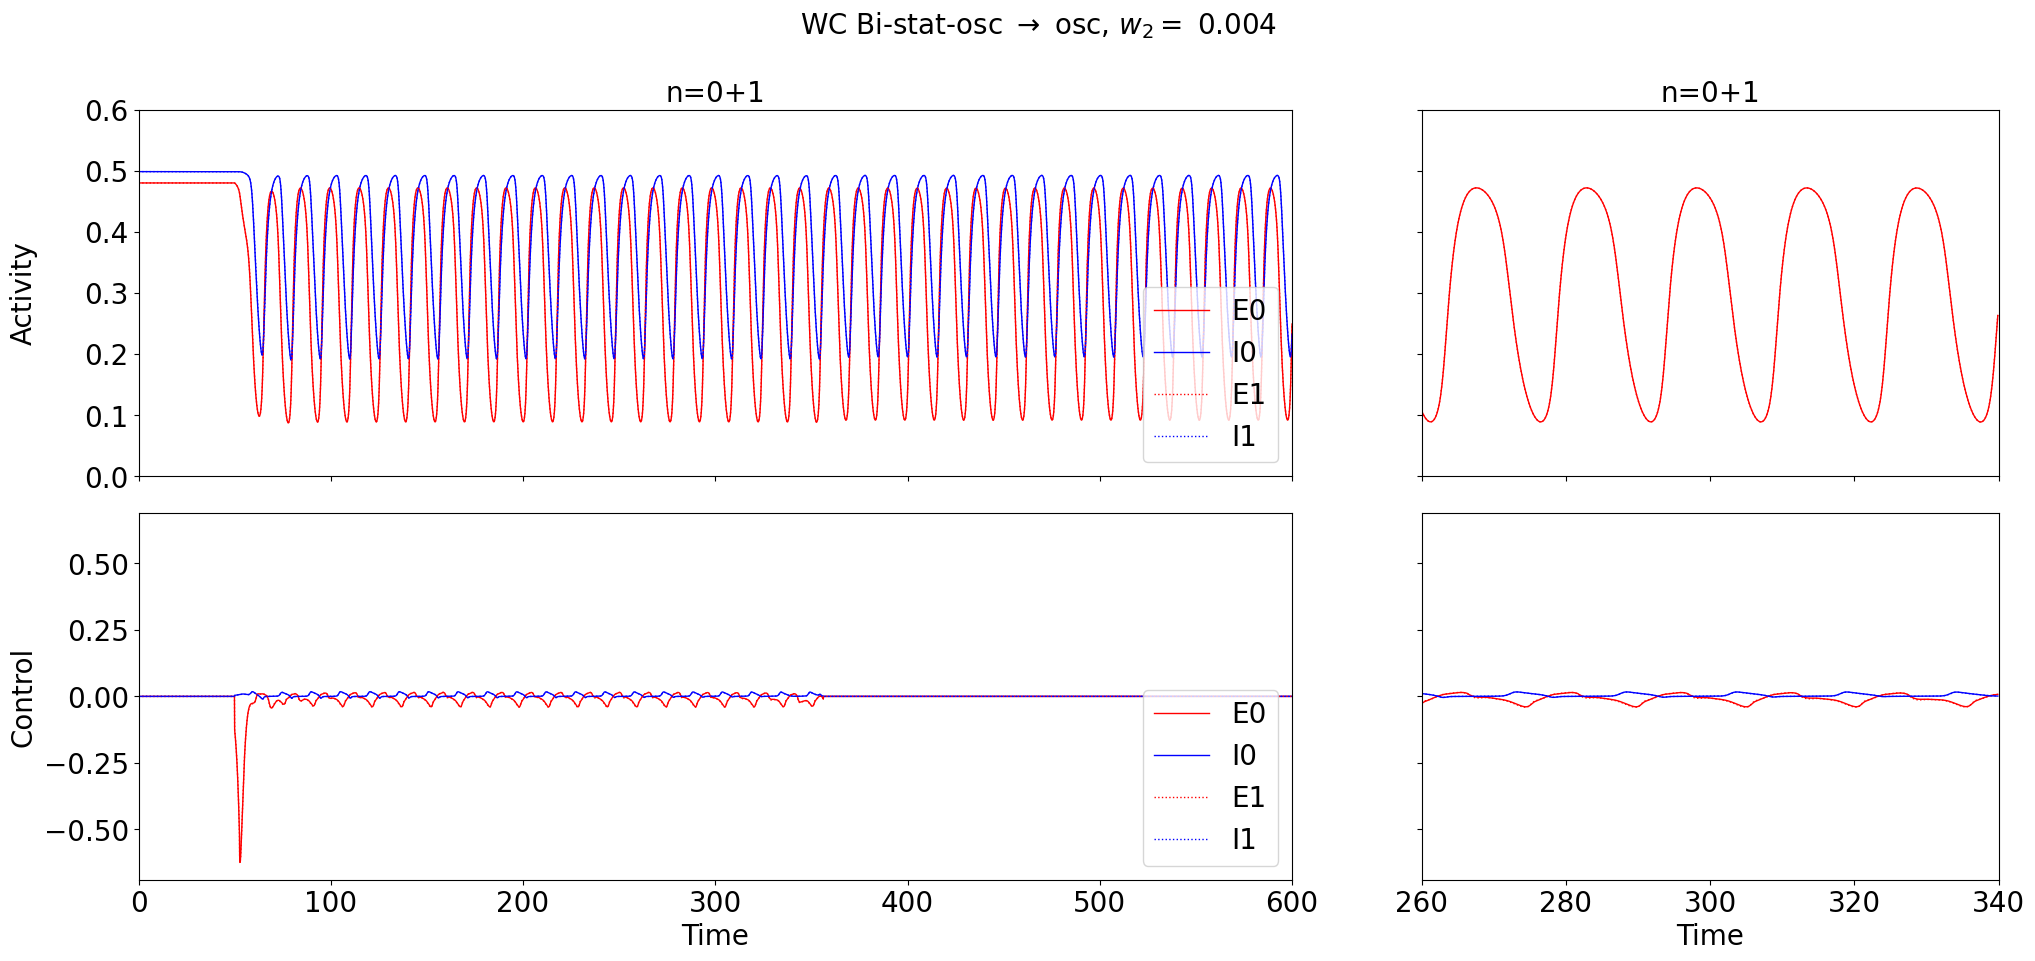

0.04


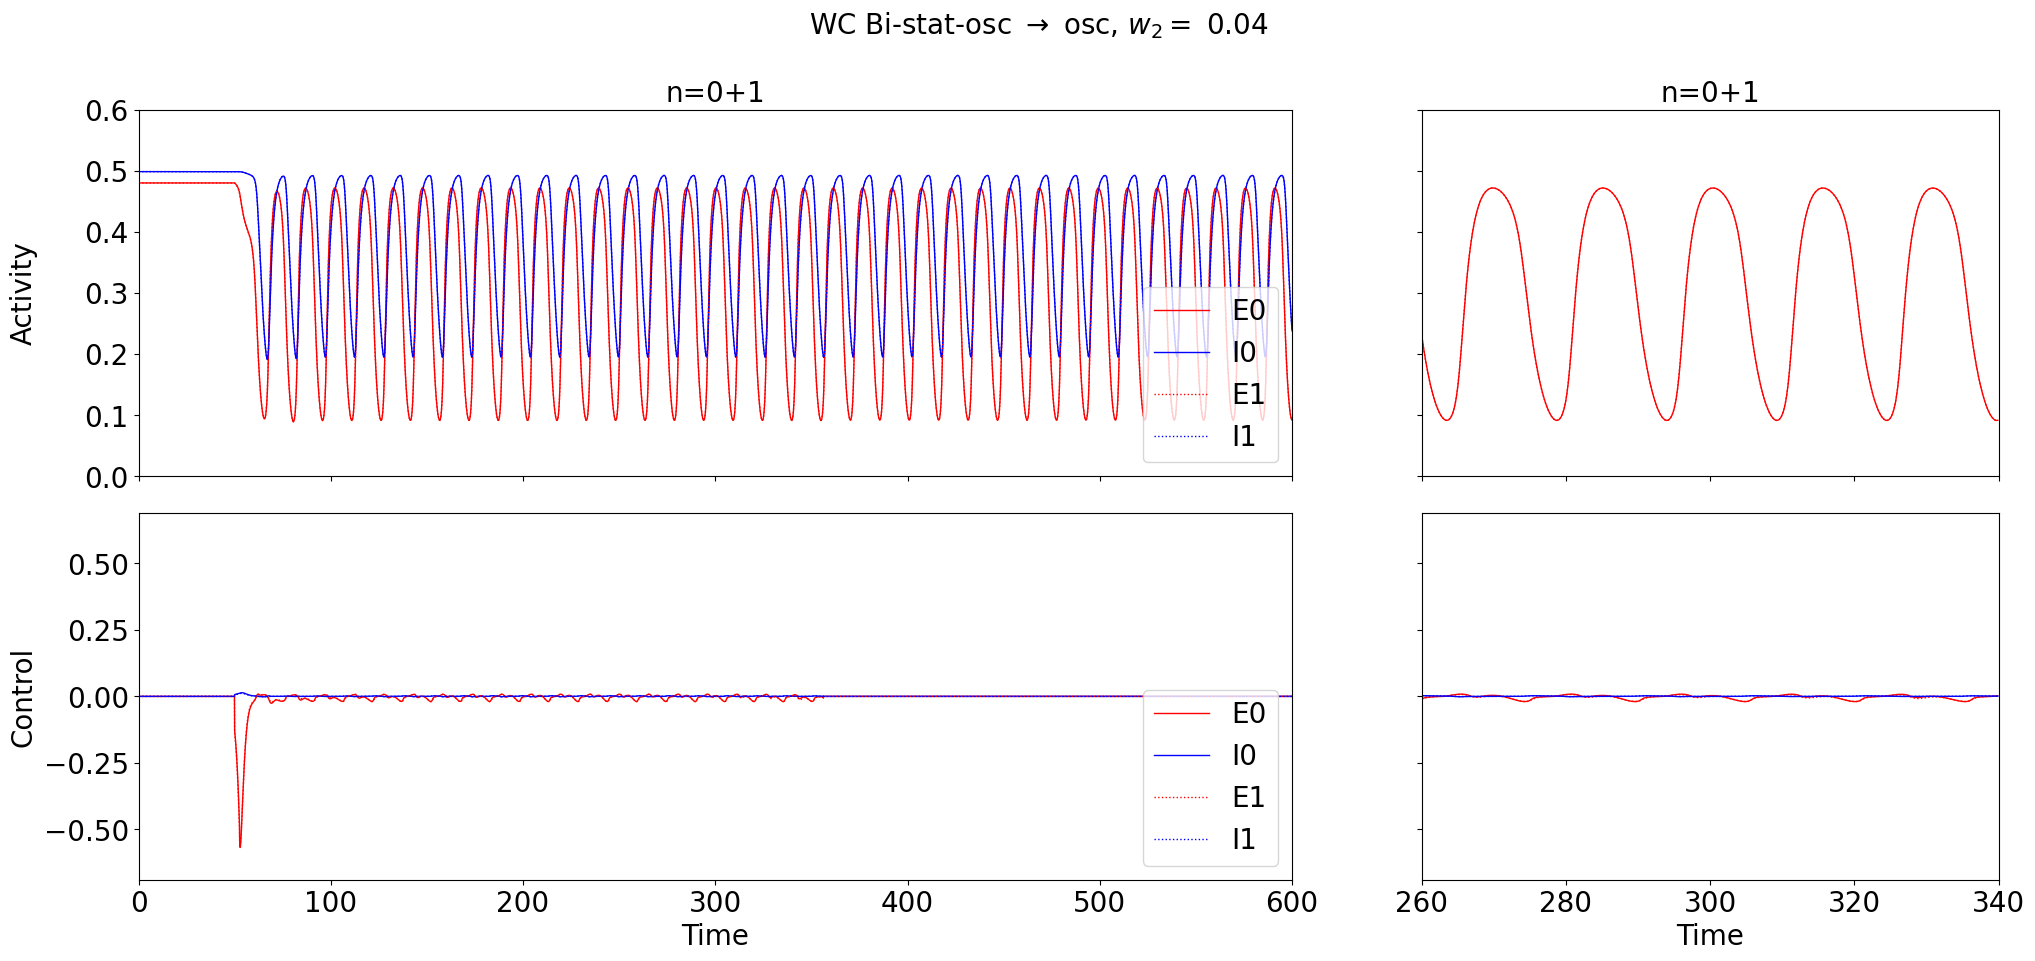

In [119]:
for pi in range(len(p_names)):
    p = p_names[pi]

    if "Bi-period" in p:
        continue

    if pi not in [4]:
        continue

    print("Point ", p)

    for wi in range(len(data[p]["weight"])):

        print(data[p]["weight"][wi])

        filename = os.path.join(dir, str(p) + "_" + str(wi) + "_Interval2.png")
        title = "WC " + p + r" $\rightarrow$ osc, $w_2 = $ " + "{}".format(data[p]["weight"][wi])
        plot_control(data[p],  data[p]["dur/per"][0], dt, wi, filename=filename, title=title)

Point  Bi-stat-osc
duration, target period =  242 3.063250114872109 0.2


Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -9.619986522032759e-34


Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x7f54189f0b80>
Traceback (most recent call last):
  File "/home/lena/.local/lib/python3.10/site-packages/llvmlite/binding/executionengine.py", line 171, in _raw_object_cache_notify
    def _raw_object_cache_notify(self, data):
KeyboardInterrupt: 


Final cost : -0.006780109449825961
Compute control for a deterministic system
Cost in iteration 0: -0.006780109449825961
Final cost : -0.007488205019694374
Compute control for a deterministic system
Cost in iteration 0: -0.007488205019694374
Final cost : -0.008202856647127171
Compute control for a deterministic system
Cost in iteration 0: -0.008202856647127171
Final cost : -0.008509606035010452


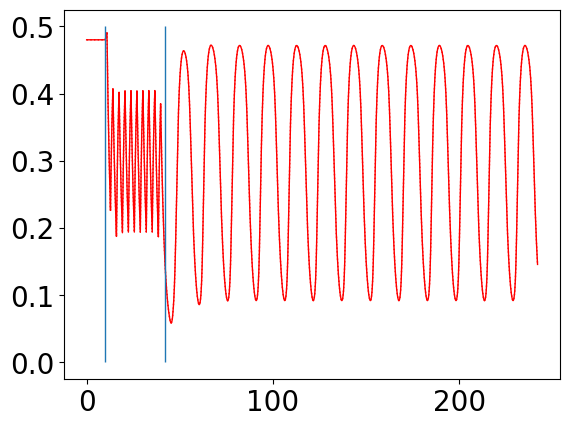

duration, target period =  274 6.126500229744218 0.4
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -6.40149265603906e-33
Converged in iteration 2 with cost -6.67167067006631e-33
Final cost : -6.67167067006631e-33
Compute control for a deterministic system
Cost in iteration 0: -6.67167067006631e-33
Final cost : -0.026054921898137615
Compute control for a deterministic system
Cost in iteration 0: -0.026054921898137615
Final cost : -0.026057770942695853
Compute control for a deterministic system
Cost in iteration 0: -0.026057770942695853
Final cost : -0.02605777122048868


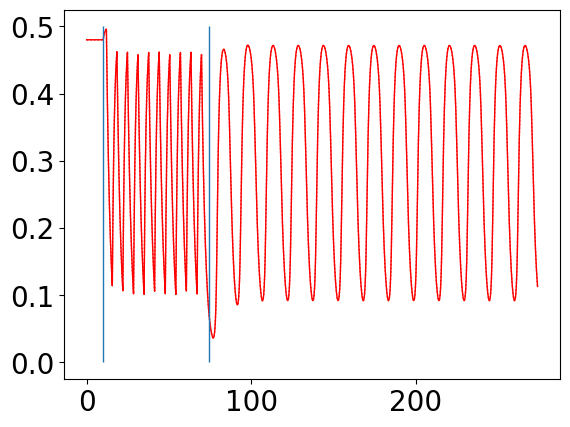

duration, target period =  306 9.189750344616328 0.6000000000000001
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -8.088190352804893e-33
Final cost : -0.04002459149932077
Compute control for a deterministic system
Cost in iteration 0: -0.04002459149932077
Final cost : -0.04106126430131395
Compute control for a deterministic system
Cost in iteration 0: -0.04106126430131395
Final cost : -0.042056825498794054
Compute control for a deterministic system
Cost in iteration 0: -0.042056825498794054
Final cost : -0.042767250240326925


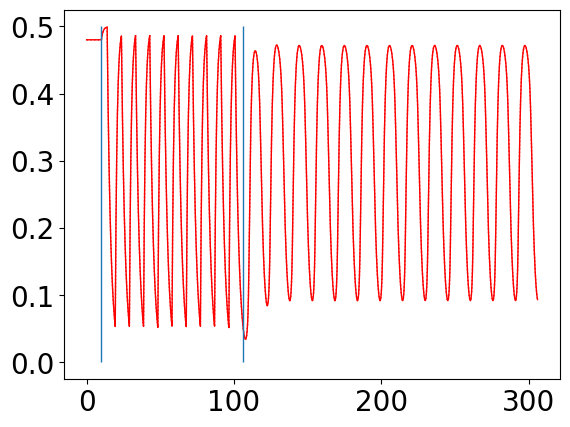

duration, target period =  338 12.253000459488437 0.8
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -5.295940513469653e-33
Final cost : -0.055097761049810304
Compute control for a deterministic system
Cost in iteration 0: -0.055097761049810304
Final cost : -0.055995806736409165
Compute control for a deterministic system
Cost in iteration 0: -0.055995806736409165
Final cost : -0.05664521013474943
Compute control for a deterministic system
Cost in iteration 0: -0.05664521013474943


KeyboardInterrupt: 

In [8]:
it = 10
pi = 4

p = p_names[pi]
print("Point ", p)

model = WCModel(Cmat=cmat, Dmat=data[p_names[pi]]["delay"]*20.*cmat)
nmaxdelay = model.getMaxDelay()

model.params["exc_ext_baseline"] =  data[p]["coordinates"][0]
model.params["inh_ext_baseline"] =  data[p]["coordinates"][1]
model.params.K_gl = coupling

model.params["exc_init"] = data[p]["init_state"][0]
model.params["inh_init"] = data[p]["init_state"][1]

for freq_fac in np.arange(0.2, 1.9, 0.2):
    
    target_period = data[p]["target_period"] * freq_fac

    int0 = 100
    int1 = int0 + int(10.5*target_period/dt)
    duration =int(int1*dt+200)
        
    model.params.duration = duration
    print("duration, target period = ", model.params.duration, target_period, freq_fac)

    zero_input0 = ZeroInput().generate_input(duration=model.params.duration+model.params.dt, dt=model.params.dt)
    zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
    zero_control = np.vstack( ([zero_input]*N))
    zero_control = np.vstack( ([zero_input]*N))
    model.params["exc_ext"] = zero_control[:,0,:]
    model.params["inh_ext"] = zero_control[:,1,:]
    model.run()

    w2 = 1e-8

    model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,int1), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat)
    model_controlled.weights["w_p"] = 0.
    model_controlled.weights["w_2"] = w2
    model_controlled.weights["w_f_sync"] = 1.

    model_controlled.maximum_control_strength = maxstr

    #model_controlled.grad_method = 1
    #model_controlled.channelwise_optimization = True

    for l in range(1):
        for k in np.arange(6., 16., 3.):
            model_controlled.zero_step_encountered = False
            model_controlled.step = 10**(k)
            model_controlled.optimize(it)

    xse = model_controlled.get_xs()[:,0,:]
    plt.plot(np.arange(0, duration+dt, dt), xse[0,:], color="red")
    plt.plot(np.arange(0, duration+dt, dt), xse[1,:], color="red", linestyle=":")
    plt.vlines([int0*dt, int1*dt], 0, 0.5)
    plt.show()

In [9]:
y0lim = [0, 0.6]

def plot_control(data, dur, dt, wi, filename=None, title=None):
    fig, ax = plt.subplots(2,2, figsize=(24,10), sharex="col", sharey="row", gridspec_kw={'width_ratios': [2, 1]})
    time_array = np.arange(0, dur+dt, dt)

    cmax = max( np.amax(np.abs(data["control"][0])), np.amax(np.abs(data["control"][1])) )
    y1lim = [-cmax* 1.1, cmax* 1.1]

    ls = ["solid", "dotted"]

    for n in range(N):
        ax[0, 0].plot(time_array, data["state"][wi][n,0,:], color="red", label="E{}".format(n), linestyle=ls[n])
        ax[0, 0].plot(time_array, data["state"][wi][n,1,:], color="blue", label="I{}".format(n), linestyle=ls[n])
        ax[1, 0].plot(time_array, data["control"][wi][n,0,:], color="red", label="E{}".format(n), linestyle=ls[n])
        ax[1, 0].plot(time_array, data["control"][wi][n,1,:], color="blue", label="I{}".format(n), linestyle=ls[n])

    i0, i1 = 2600, 3400
    time_array = np.arange(i0*dt, i1*dt, dt)
    ax[0, 1].plot(time_array, data["state"][wi][0,0,i0:i1], color="red", label="N0")
    ax[0, 1].plot(time_array, data["state"][wi][1,0,i0:i1], color="red", linestyle=":", label="N1")
    ax[1, 1].plot(time_array, data["control"][wi][0,0,i0:i1], color="red")
    ax[1, 1].plot(time_array, data["control"][wi][1,0,i0:i1], color="red", linestyle=":")
    ax[1, 1].plot(time_array, data["control"][wi][0,1,i0:i1], color="blue")
    ax[1, 1].plot(time_array, data["control"][wi][1,1,i0:i1], color="blue", linestyle=":")

    ax[0,0].legend(loc="lower right")
    ax[1,0].legend(loc="lower right")

    ax[0,0].set_xlim(0, dur)
    ax[0,1].set_xlim(i0*dt, i1*dt)

    ax[0,0].set_ylim(y0lim)
    ax[1,0].set_ylim(y1lim)

    ax[1,0].set_xlabel("Time")
    ax[1,1].set_xlabel("Time")
    ax[0,0].set_ylabel("Activity")
    ax[1,0].set_ylabel("Control")

    ax[0,0].set_title("n=0+1")
    ax[0,1].set_title("n=0+1")

    plt.subplots_adjust(
                    wspace=0.15,
                    hspace=0.1)
    
    fig.align_ylabels([ax[:,0]])
    
    if title is not None:
        fig.suptitle(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', dpi=200)

    plt.show()
    return

In [19]:
with open(os.path.join(pickledir, '2n_wc_oscillations_fourier.pickle'), 'wb') as f:
    pickle.dump(data, f)

In [10]:
with open(os.path.join(pickledir, '2n_wc_oscillations_fourier.pickle'), 'rb') as f:
    res_read = pickle.load(f)
    print(res_read.keys() )

data = res_read.copy()

dict_keys(['Osc', 'Bi-phase-osc', 'Beat', 'Bi-period-osc', 'Bi-stat-osc'])


In [28]:
y0lim = [0, 0.6]

def plot_control_bi(data, dur, dt, wi, ii, filename=None, title=None):
    fig, ax = plt.subplots(2,2, figsize=(24,10), sharex="col", sharey="row", gridspec_kw={'width_ratios': [2, 1]})
    time_array = np.arange(0, dur+dt, dt)

    cmax = max( np.amax(np.abs(data["control"][ii][0])), np.amax(np.abs(data["control"][ii][1])) )
    y1lim = [-cmax* 1.1, cmax* 1.1]

    ls = ["solid", "dotted"]

    for n in range(N):
        ax[0, 0].plot(time_array, data["state"][ii][wi][n,0,:], color="red", label="E{}".format(n), linestyle=ls[n])
        ax[0, 0].plot(time_array, data["state"][ii][wi][n,1,:], color="blue", label="I{}".format(n), linestyle=ls[n])
        ax[1, 0].plot(time_array, data["control"][ii][wi][n,0,:], color="red", label="E{}".format(n), linestyle=ls[n])
        ax[1, 0].plot(time_array, data["control"][ii][wi][n,1,:], color="blue", label="I{}".format(n), linestyle=ls[n])

    i0, i1 = 3000, 3800
    time_array = np.arange(i0*dt, i1*dt, dt)
    ax[0, 1].plot(time_array, data["state"][ii][wi][0,0,i0:i1], color="red", label="N0")
    ax[0, 1].plot(time_array, data["state"][ii][wi][1,0,i0:i1], color="red", linestyle=":", label="N1")
    ax[1, 1].plot(time_array, data["control"][ii][wi][0,0,i0:i1], color="red")
    ax[1, 1].plot(time_array, data["control"][ii][wi][1,0,i0:i1], color="red", linestyle=":")
    ax[1, 1].plot(time_array, data["control"][ii][wi][0,1,i0:i1], color="blue")
    ax[1, 1].plot(time_array, data["control"][ii][wi][1,1,i0:i1], color="blue", linestyle=":")

    ax[0,0].legend(loc="lower right")
    ax[1,0].legend(loc="lower right")

    ax[0,0].set_xlim(0, dur)
    ax[0,1].set_xlim(i0*dt, i1*dt)

    ax[0,0].set_ylim(y0lim)
    ax[1,0].set_ylim(y1lim)

    ax[1,0].set_xlabel("Time")
    ax[1,1].set_xlabel("Time")
    ax[0,0].set_ylabel("Activity")
    ax[1,0].set_ylabel("Control")

    ax[0,0].set_title("n=0+1")
    ax[0,1].set_title("n=0+1")

    plt.subplots_adjust(
                    wspace=0.15,
                    hspace=0.1)
    
    fig.align_ylabels([ax[:,0]])
    
    if title is not None:
        fig.suptitle(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', dpi=200)

    plt.show()
    return

In [210]:
data["Bi-period-osc"]["weight"] = [[1. * 1e-4, 1. * 1e-3], [1. * 1e-4, 1. * 1e-3]]
data["Bi-period-osc"]["dur/per"] = [[600., 20], [600., 20]]

In [231]:
it = 10

for pi in range(len(p_names)):
    p = p_names[pi]

    if "Bi-period" not in p:
        continue

    print("Point ", p)

    for i_init in range(2):

        target_period_index = 1
        if i_init == 1:
            target_period_index = 0

        target_period = data[p]["target_period"][target_period_index]

        model = WCModel(Cmat=cmat, Dmat=data[p_names[pi]]["delay"]*20.*cmat)
        nmaxdelay = model.getMaxDelay()
        print("target period, max delay = ", target_period, nmaxdelay)

        model.params["exc_ext_baseline"] =  data[p]["coordinates"][0]
        model.params["inh_ext_baseline"] =  data[p]["coordinates"][1]
        model.params.K_gl = coupling
            
        model.params.duration = data[p]["dur/per"][i_init][0]
        print("duration = ", model.params.duration)

        zero_input0 = ZeroInput().generate_input(duration=model.params.duration+model.params.dt, dt=model.params.dt)
        zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
        zero_control = np.vstack( ([zero_input]*N))
        zero_control = np.vstack( ([zero_input]*N))
        model.params["exc_ext"] = zero_control[:,0,:]
        model.params["inh_ext"] = zero_control[:,1,:]

        model.params["exc_init"] = data[p]["init_state"][i_init][0]
        model.params["inh_init"] = data[p]["init_state"][i_init][1]

        model.run()
        
        int0 = 500
        int1 = int0 + int(data[p]["dur/per"][i_init][1]*target_period/dt)

        for wi, w2 in enumerate(data[p]["weight"][i_init]):

            print("w2 = ",w2)

            #for factor in np.random.random(1):
            for factor in [1]:

                model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,None), control_interval=(int0, int1), 
                                            cost_matrix=costmat, control_matrix=controlmat)
                
                model_controlled.weights["w_p"] = 0.
                model_controlled.weights["w_2"] = w2 * factor
                model_controlled.weights["w_f_sync"] = 1. 

                model_controlled.maximum_control_strength = maxstr

                if True:
                    if type(data[p]["control"][i_init][wi]) != type(None):
                        model_controlled.control = data[p]["control"][i_init][wi].copy()
                        model_controlled.update_input()

                model_controlled.simulate_forward()

                #model_controlled.grad_method = 1
                model_controlled.channelwise_optimization = True

                for l in range(1):
                    for k in np.arange(-10., 10., 2.):
                        model_controlled.zero_step_encountered = False
                        model_controlled.step = 10**(k)
                        model_controlled.optimize(it)

                data[p]["control"][i_init][wi] = model_controlled.control.copy()
                data[p]["state"][i_init][wi] = model_controlled.get_xs()

                mod = copy.deepcopy(model_controlled.model)
                mod.params.duration = 2000.
                input = np.zeros((2,2,1+int(mod.params.duration/dt)))
                input[:,:,:6001] = model_controlled.control.copy()
                mod.params.exc_ext = input[:,0,:]
                mod.params.inh_ext = input[:,1,:]
                mod.run()

                plt.plot(np.arange(0,mod.params.duration,dt), mod.exc[0,:], color="red")
                plt.plot(np.arange(0,mod.params.duration,dt), mod.exc[1,:], color="red", linestyle=":")
                plt.ylim(0,0.5)
                plt.show()

        plot_control_bi(data[p], data[p]["dur/per"][i_init][0], dt, 0, i_init)
        plot_control_bi(data[p], data[p]["dur/per"][i_init][0], dt, 1, i_init)

with open(os.path.join(pickledir, '2n_wc_oscillations_fourier.pickle'), 'wb') as f:
    pickle.dump(data, f)

Point  Bi-period-osc
target period, max delay =  18.106065544088356 95
duration =  600.0
w2 =  0.0001
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.013357055596699112
Final cost : -0.013357055597442193
Compute control for a deterministic system
Cost in iteration 0: -0.013357055597442193
Final cost : -0.013357055671740975
Compute control for a deterministic system
Cost in iteration 0: -0.013357055671740975
Final cost : -0.013357063096303613
Compute control for a deterministic system
Cost in iteration 0: -0.013357063096303613
Final cost : -0.013357755400707409
Compute control for a deterministic system
Cost in iteration 0: -0.013357755400707409


Point  Bi-period-osc
[0.0001, 0.001]


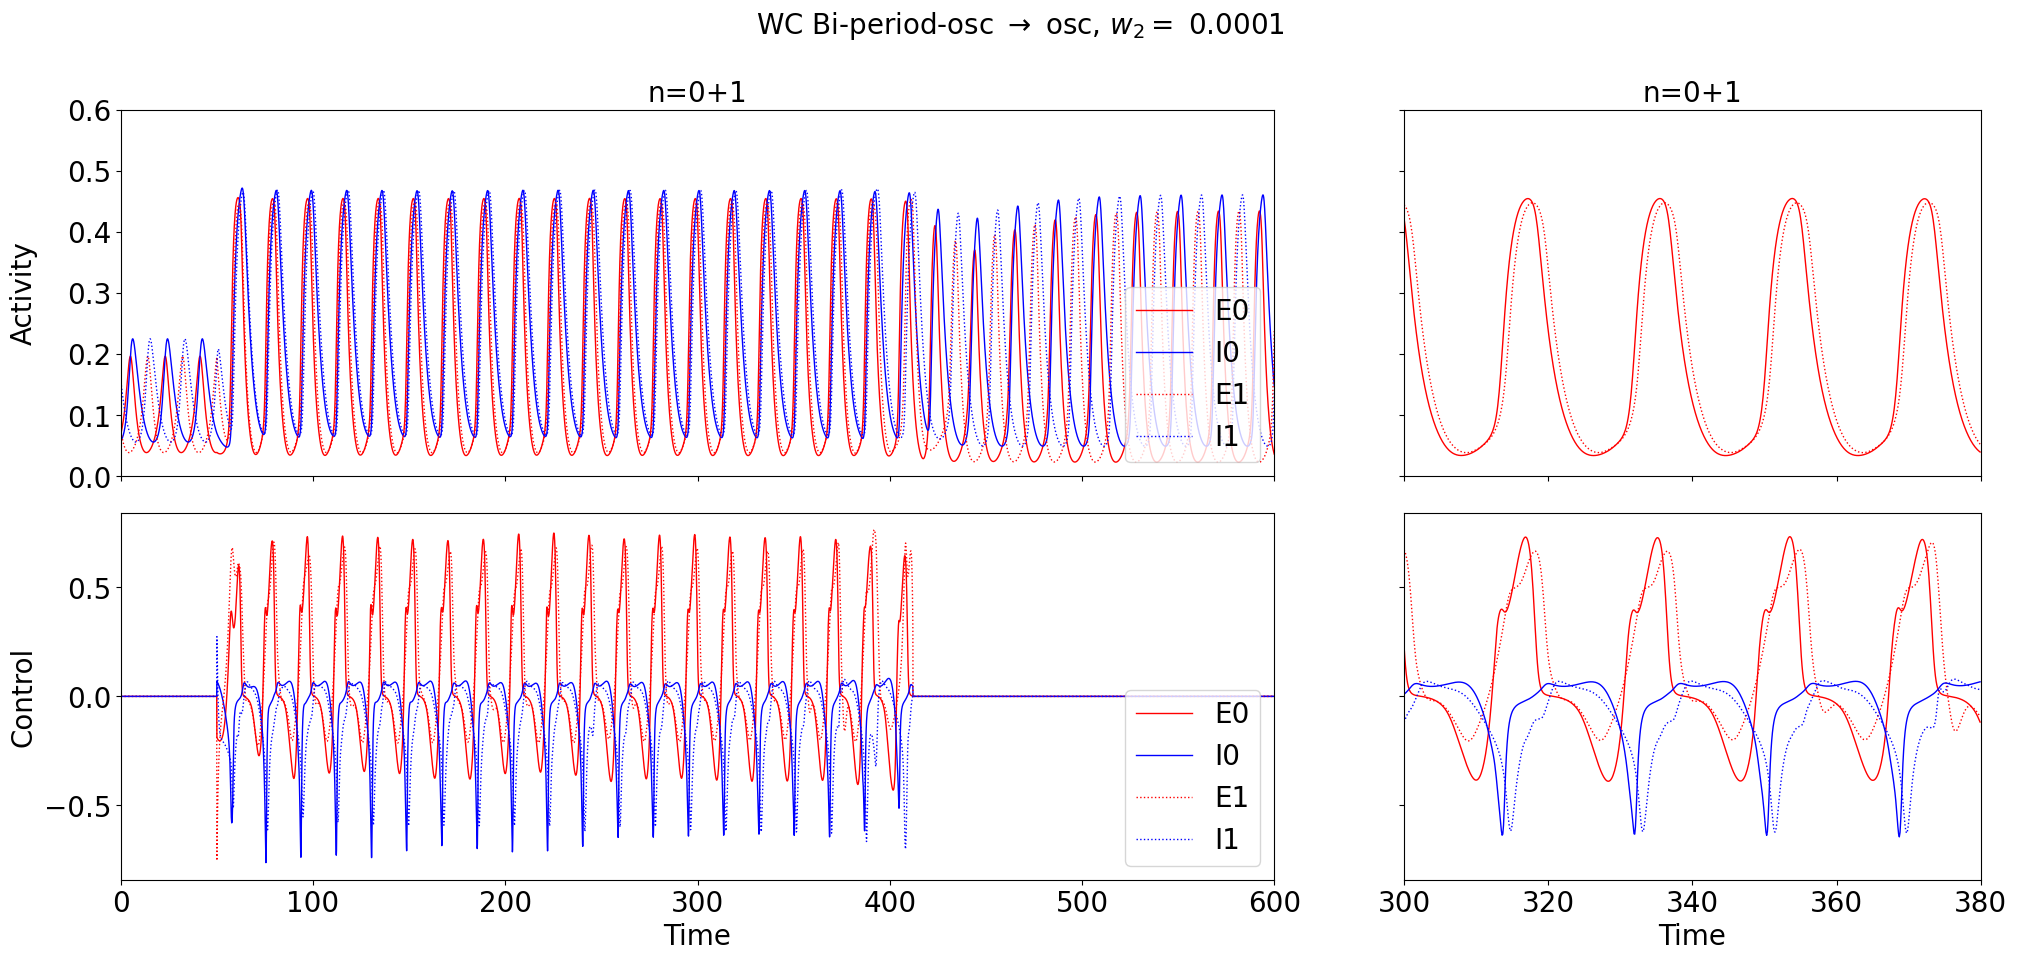

[0.0001, 0.001]


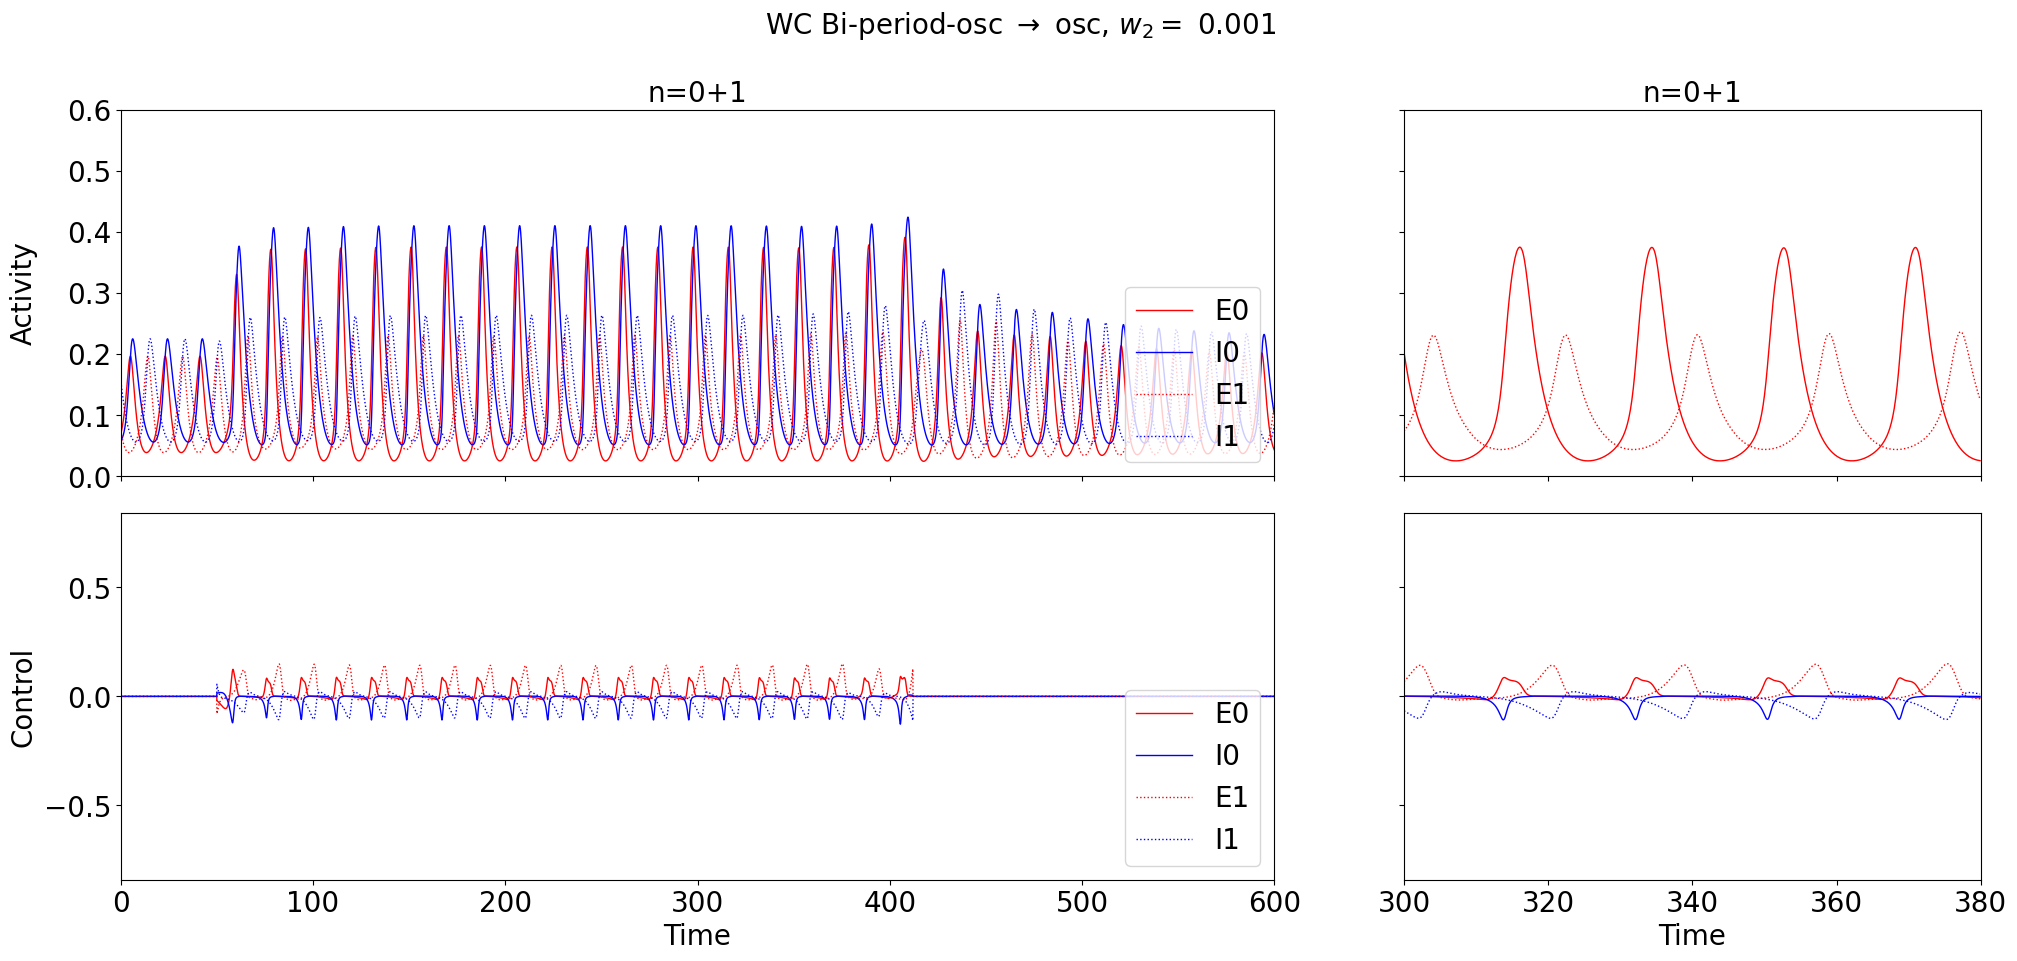

[0.0001, 0.001]


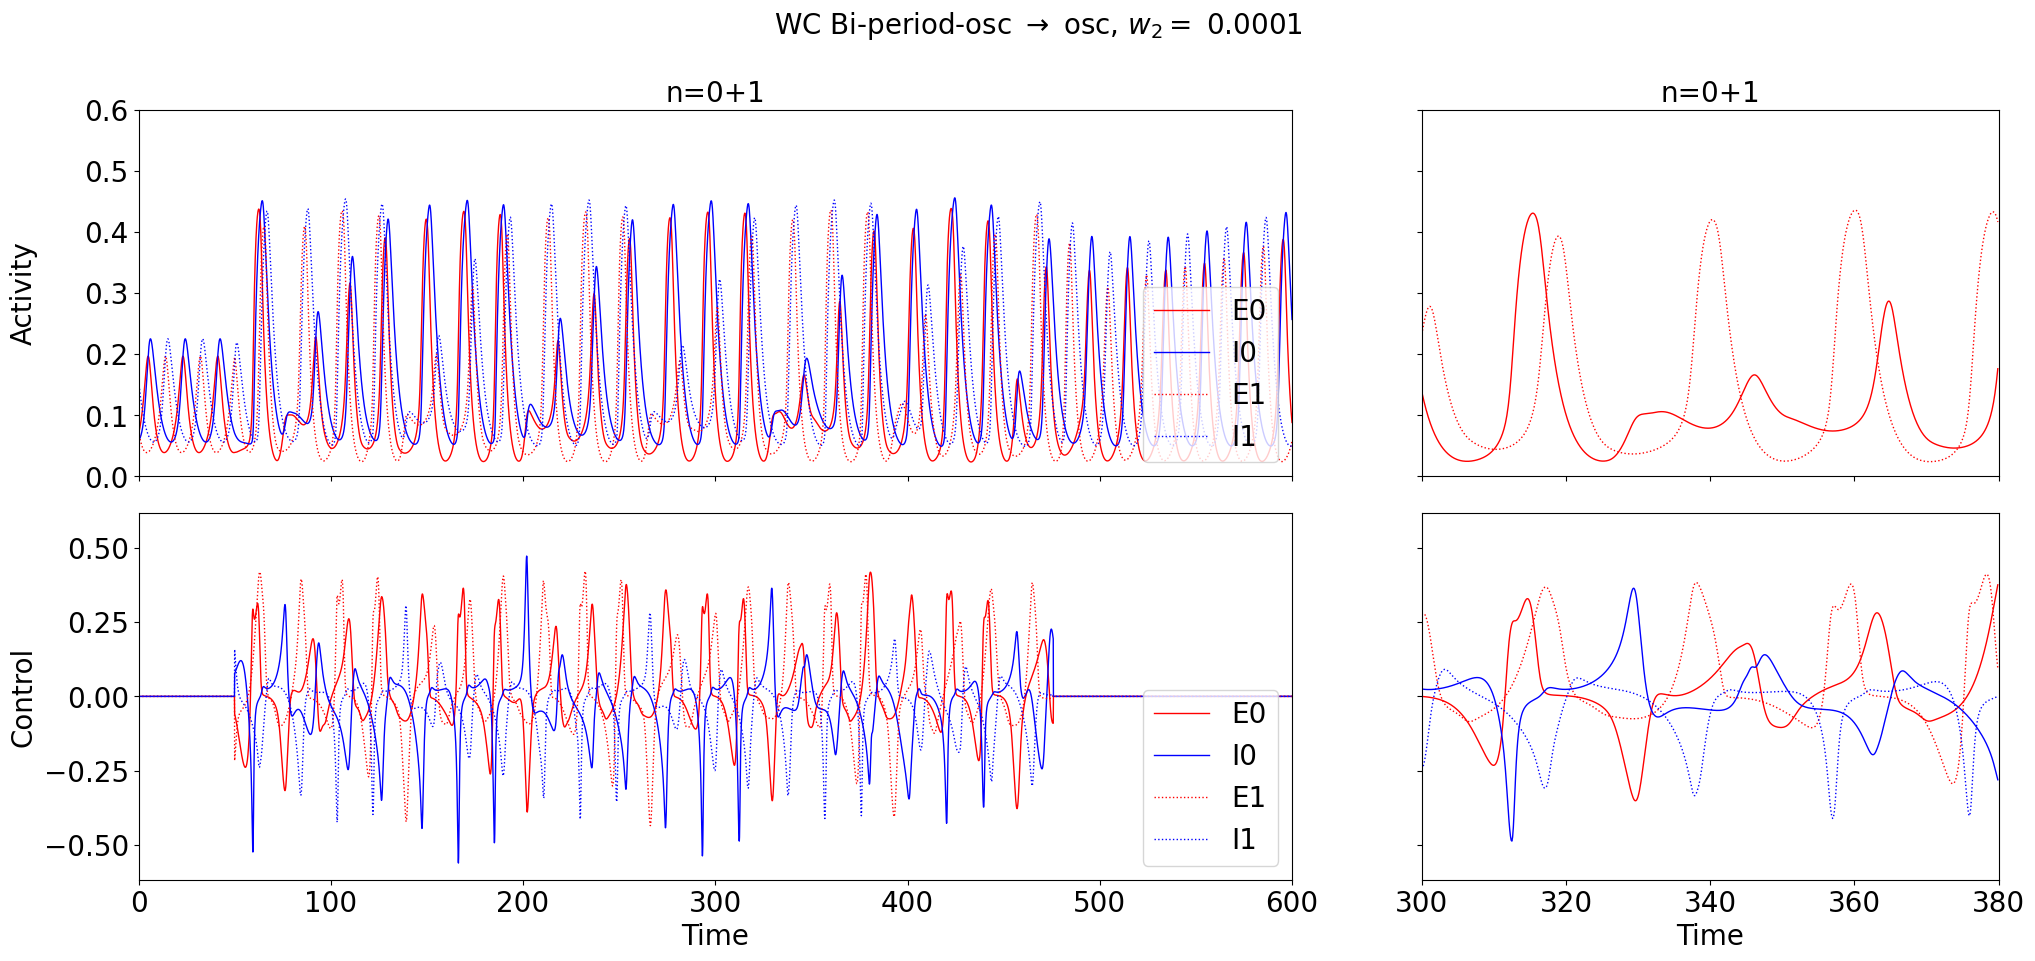

[0.0001, 0.001]


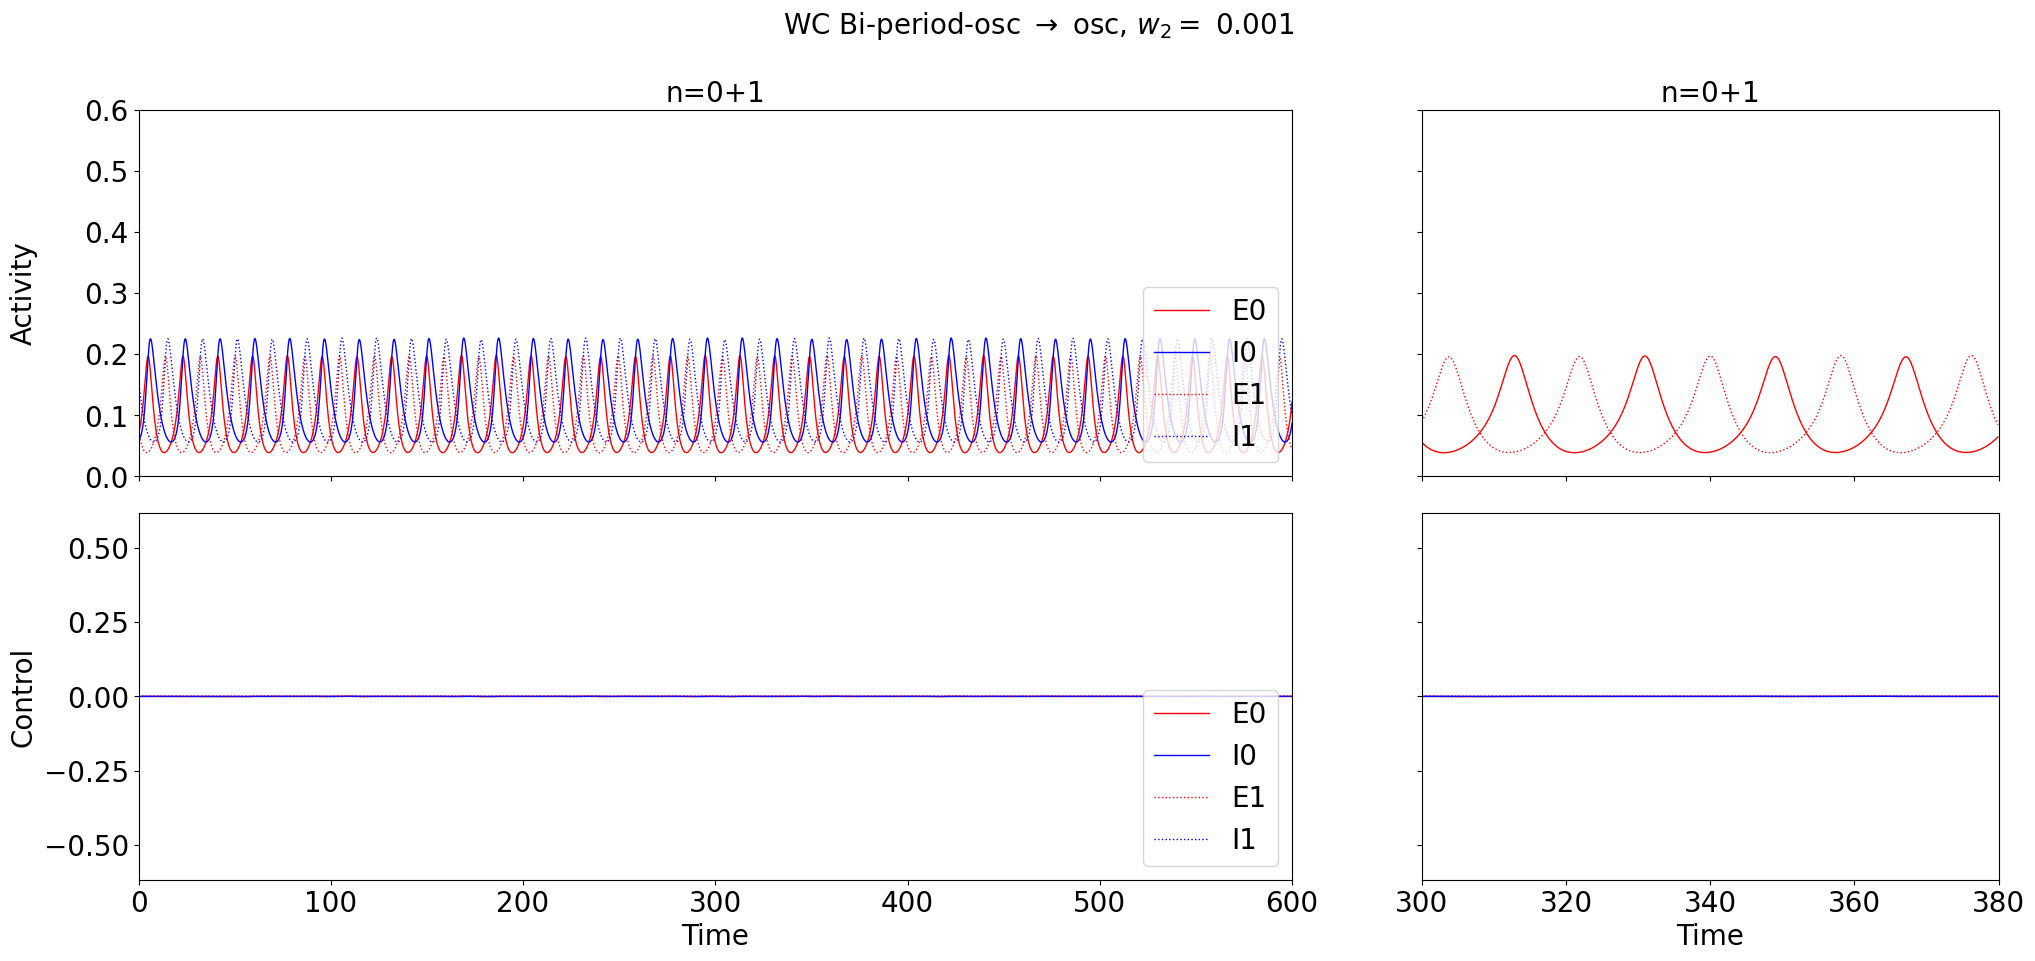

In [230]:
for pi in range(len(p_names)):
    p = p_names[pi]

    if "Bi-period" not in p:
        continue

    print("Point ", p)   

    for i_init in range(2):

        for wi in range(len(data[p]["weight"])):

            print(data[p]["weight"][wi])

            filename = os.path.join(dir, str(p) + "_" + str(i_init) + "_" + str(wi) + ".png")
            title = "WC " + p + r" $\rightarrow$ osc, $w_2 = $ " + "{}".format(data[p]["weight"][i_init][wi])
            plot_control_bi(data[p],  data[p]["dur/per"][i_init][0], dt, wi, i_init, filename=filename, title=title)